## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

## Data Cleaning

In [67]:
household_data = pd.read_excel('household.xlsx', sheet_name='Sheet1')

In [ ]:
dict(household_data.isnull().sum())

In [68]:
household_data = household_data[~household_data['HH48'].isnull()]

In [69]:
def drop_cols(df, null_percentage):
    '''The function drops the columns which have null percentage greater than given null percentage by the user,
    INPUTS:
        df = The dataframe from which columns need to be dropped
        null_percentage = A numerical figure provided by user which acts as a threshold for null_percenatge 
    OUTPUT
        The function returns True if all columns are dropped successfully else it returns False
    '''
    try:
        total_rows = len(df)
        for column in df.columns:
            if (df[column].isnull().sum() / total_rows)*100> null_percentage:
                df.drop(columns=column, inplace=True)
        return True
    except Exception as e:
        logging.error("Exception occurred at drop_cols", exc_info=True)
        return False
if drop_cols(household_data, 50):
    print('Columns Dropped Successfully')
else:
    print('Unable to drop columns check logs for more info')

Columns Dropped Successfully


In [ ]:
dict(household_data.isnull().sum())

In [70]:
'''Households which dont have access to Electricity wont have access to electrical appliacnces as well,
   thus filling up the values with NO'''

col_list = ['HC9B',
 'HC9G',
 'HC9H',
 'HC9K',
 'HC9L',
 'HC9M',
 'HC9N',
 'HC9P']
household_data.loc[household_data['HC8']=='NO', col_list]='NO'

In [ ]:
for col in col_list:
    print(pd.DataFrame(household_data[col].value_counts()))

In [ ]:
'''Filling Blanks in Source of Fuel for cooking'''
household_data.loc[household_data['EU1']=='NO FOOD COOKED IN HOUSEHOLD', ['EU4', 'EU5']]='NONE'
household_data.loc[household_data['EU4'].isnull(), 'EU4'] = 'OTHER'

In [ ]:
'''For households with no mosqiuto nets, filling up data with 0'''
household_data['TN2'].fillna(0, inplace=True)

Filling up blanks for water sources

In [ ]:
household_data.loc[(household_data['WS1']=='PIPED WATER: PIPED TO YARD / PLOT')&(household_data['WS3'].isnull()), 'WS3'] ='IN OWN YARD / PLOT'
household_data.loc[(household_data['WS1']=='PIPED WATER : PIPED INTO DWELLING')&(household_data['WS3'].isnull()), 'WS3'] ='IN OWN DWELLING'
household_data['WS3'].fillna('ELSEWHERE', inplace=True)

In [ ]:
household_data.loc[household_data['WS4']=='MEMBERS DO NOT COLLECT','WS4'] = 0

In [ ]:
household_data[household_data['WS4'].isnull()]['WS1'].value_counts()

In [ ]:
household_data.drop(columns='WS4', inplace=True)#Dropping column because of high skewness and not much relevance to target

In [ ]:
household_data.drop(columns=['WS5', 'WS6'], inplace=True)

In [ ]:
household_data['WS12'].fillna('None', inplace=True)

In [ ]:
household_data['WS14'].fillna('ELSEWHERE', inplace=True)

In [ ]:
household_data['WS15'].fillna('YES', inplace=True)

In [ ]:
household_data['WS16'] = np.where((household_data['WS16'].isnull())&(household_data['WS15']=='NO'),'NOT SHARED', household_data['WS16'])


In [ ]:
household_data['WS16'].fillna('SHARED WITH GENERAL PUBLIC', inplace=True)

In [ ]:
household_data['HW2'] = np.where((household_data['HW2'].isnull())&(household_data['HW1']=='NOT OBSERVED: NO HANDWASHING PLACE IN DWELLING / YARD / PLOT'),'WATER IS NOT AVAILABLE', household_data['HW2'])
household_data['HW2'].fillna('NO RESPONSE', inplace=True)

In [ ]:
household_data['HW3'] = np.where((household_data['HW3'].isnull())&(household_data['HW1']=='NOT OBSERVED: NO HANDWASHING PLACE IN DWELLING / YARD / PLOT'),'NO, NOT PRESENT', household_data['HW3'])
household_data['HW3'].fillna('NO RESPONSE', inplace=True)

In [ ]:
household_data['HW5'].fillna('NO', inplace=True)

In [ ]:
household_data['HW8A'].fillna('NO RESPONSE', inplace=True)
household_data['HW8C'].fillna('NO RESPONSE', inplace=True)
household_data['HW9A'].fillna('NO RESPONSE', inplace=True)


In [ ]:
dict(household_data.isnull().sum())

## Merging

In [83]:
birth_data = pd.read_spss(r'./Ghana MICS6 SPSS Datasets/bh.sav', usecols = ['HH1', 'HH2','BH2', 'BH3', 'BH4Y','BH5', 'BH6','BH9U', 'BH9N', 'BH10', 'brthord', 'magebrt', 'birthint', 'welevel', 'disability', 'BH4Y_first','BH6_first', 'BH3_last', 'BH4Y_last', 'BH6_last','wmweight'])

In [ ]:
birth_data.isnull().sum()

In [ ]:
birth_data['disability'].value_counts()

In [72]:
birth_data['BH9N'] = birth_data['BH9N'].astype(str)
temp_df = birth_data[birth_data['BH6'].isnull()]

In [73]:
temp_df['BH6'] = np.where(temp_df['BH9U']=='YEARS', temp_df['BH9N'].astype(float), temp_df['BH6'])
temp_df['BH6'] = np.where(temp_df['BH9U']=='MONTHS', temp_df['BH9N'].astype(float)/12, temp_df['BH6'])
temp_df['BH6'] = np.where(temp_df['BH9U']=='DAYS', temp_df['BH9N'].astype(float)/365, temp_df['BH6'])

<ipython-input-73-c7bc6b4a7b7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['BH6'] = np.where(temp_df['BH9U']=='YEARS', temp_df['BH9N'].astype(float), temp_df['BH6'])
<ipython-input-73-c7bc6b4a7b7d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['BH6'] = np.where(temp_df['BH9U']=='MONTHS', temp_df['BH9N'].astype(float)/12, temp_df['BH6'])
<ipython-input-73-c7bc6b4a7b7d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [74]:
birth_data['BH6'] = birth_data['BH6'].astype('str').astype('float')

In [75]:
birth_data[birth_data['BH6'].isnull()] = temp_df 

In [76]:
birth_data.drop(columns=['BH4Y_first','BH6_first','BH3_last','BH4Y_last','BH6_last'], inplace=True)
birth_data = birth_data[birth_data['disability'].notnull()]

In [77]:
birth_data.drop(columns=['BH9U','BH9N'], inplace=True)

In [78]:
birth_data.isnull().sum()

HH1           0
HH2           0
BH2           0
BH3           0
BH4Y          0
BH5           0
BH6           0
BH10          0
brthord       0
magebrt       0
birthint      0
welevel       0
disability    0
wmweight      0
dtype: int64

In [79]:
birth_data_less_than_five = birth_data[birth_data['BH6']<=5]

In [ ]:
birth_data_less_than_five.shape

In [ ]:
final_merged_data = household_data.merge(birth_data_less_than_five, on=['HH1', 'HH2'], how='inner')

In [2]:
# final_merged_data = pd.read_csv('dataset2.csv')

C:\Users\cheta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (77) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
for column in final_merged_data.columns:
    if final_merged_data[column].dtypes=='O':
        final_merged_data[column] = final_merged_data[column].astype('category')

In [ ]:
dict(final_merged_data.dtypes)

In [ ]:
final_merged_data.shape

In [4]:
final_df = final_merged_data.drop(columns=['wscorer','windex5', 'windex10r'])

In [ ]:
final_df.shape

## Feature Engineering

In [5]:
cols_to_transform=[]
for column in final_df.columns:
    if final_df[column].dtype !=float:
        cols_to_transform.append(column)

In [ ]:
dict(final_df[cols_to_transform].dtypes)

In [ ]:
final_df.columns

In [6]:
feature_df = final_df[cols_to_transform].astype('str').astype('category').apply(LabelEncoder().fit_transform)

In [7]:
target = feature_df['BH5']

In [8]:
feature_df = feature_df.drop(columns ='BH5')

### Oversampling

<AxesSubplot:>

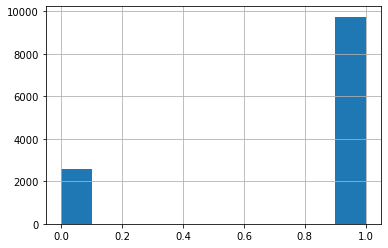

In [10]:
target.hist()

In [9]:
adasyn = ADASYN()

X_adasyn, y_adasyn = adasyn.fit_resample(feature_df,target)



In [11]:
print('The number of lines before oversampling : {}'.format(feature_df[feature_df.columns[1:]].shape[0]))
print('The number of lines after oversampling : {}'.format(X_adasyn.shape[0]))

The number of lines before oversampling : 12355
The number of lines after oversampling : 19324


### Selecting features using chi2 test

Feature 0: 1396.045890
Feature 1: 78.552221
Feature 2: 26.733969
Feature 3: 6.588440
Feature 4: 77.351174
Feature 5: 57.092737
Feature 6: 0.433770
Feature 7: 0.603313
Feature 8: 1.057324
Feature 9: 110.157163
Feature 10: 210.464425
Feature 11: 142.706887
Feature 12: 0.235958
Feature 13: 139.423467
Feature 14: 128.734346
Feature 15: 45.242228
Feature 16: 242.995643
Feature 17: 53.249304
Feature 18: 31.253882
Feature 19: 11.184691
Feature 20: 30.908135
Feature 21: 256.121502
Feature 22: 2.781440
Feature 23: 105.889767
Feature 24: 48.126126
Feature 25: 123.384333
Feature 26: 29.968309
Feature 27: 153.714589
Feature 28: 12.991942
Feature 29: 29.707111
Feature 30: 59.982161
Feature 31: 273.194845
Feature 32: 19.765852
Feature 33: 328.629775
Feature 34: 36.237412
Feature 35: 33.728216
Feature 36: 223.245571
Feature 37: 29.116529
Feature 38: 29.131123
Feature 39: 14.219338
Feature 40: 0.992563
Feature 41: 28.176925
Feature 42: 55.138380
Feature 43: 0.673601
Feature 44: 15.761995
Feature 45: 1

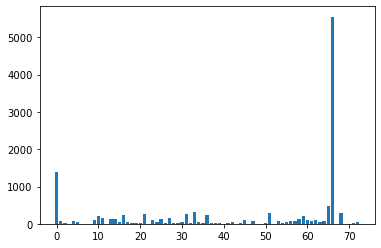

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_adasyn,
                                                      y_adasyn,
                                                      test_size=0.3,
                                                      random_state=50)
chi2_fs = SelectKBest(score_func=chi2, k=15)
chi2_fs.fit(X_train, y_train)
X_train_fs = chi2_fs.transform(X_train)
X_test_fs = chi2_fs.transform(X_test)
for i in range(len(chi2_fs.scores_)):
    print('Feature %d: %f' % (i, chi2_fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(chi2_fs.scores_))], chi2_fs.scores_)
plt.show()

### Selecting features using RandomForest

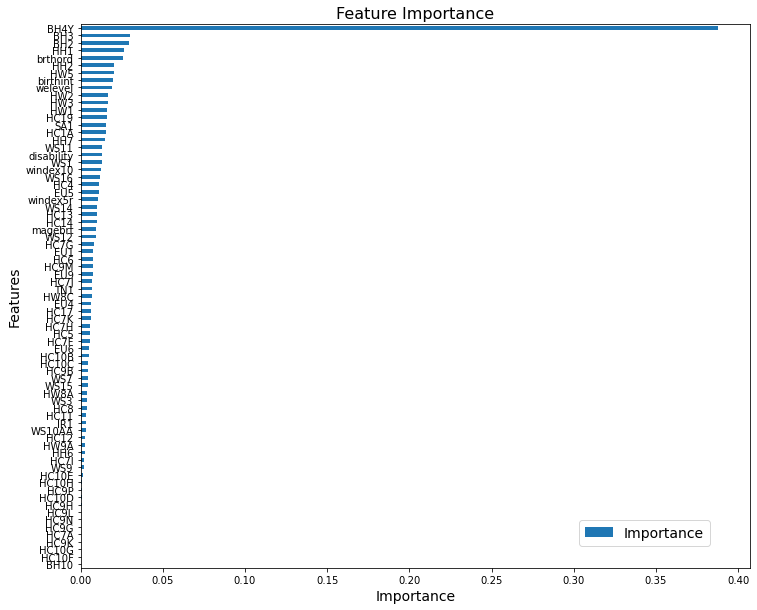

In [13]:
rf_fs = RandomForestClassifier(random_state=1)
rf_fs.fit(X_adasyn,y_adasyn)
importance = list(rf_fs.feature_importances_)
colum = list(X_adasyn.columns)

feature_importance = pd.DataFrame(zip(colum, importance), columns=['Feature', 'Importance']).sort_values('Importance')

feature_importance = feature_importance.set_index('Feature')

feature_importance.plot(kind='barh', figsize=(12,10))
plt.title('Feature Importance', fontsize=16)
plt.legend(bbox_to_anchor=(0.95, 0.1), fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.show()



In [14]:
cols_to_feature = list(feature_importance.sort_values(by='Importance', ascending=False).head(15).index)

In [15]:
featured_df_rf = X_adasyn[cols_to_feature]

In [65]:
featured_df_rf.columns

Index(['BH4Y', 'BH3', 'BH2', 'HH1', 'brthord', 'HH2', 'HW5', 'birthint',
       'welevel', 'HW2', 'HW3', 'HW1', 'HC19', 'SA1', 'HC1A'],
      dtype='object')

In [17]:
X_train_rf_fs, X_test_rf_fs, y_train, y_test = train_test_split(featured_df_rf,
                                                          y_adasyn,
                                                          test_size=0.3,
                                                          random_state=50)

### Correlation

<AxesSubplot:>

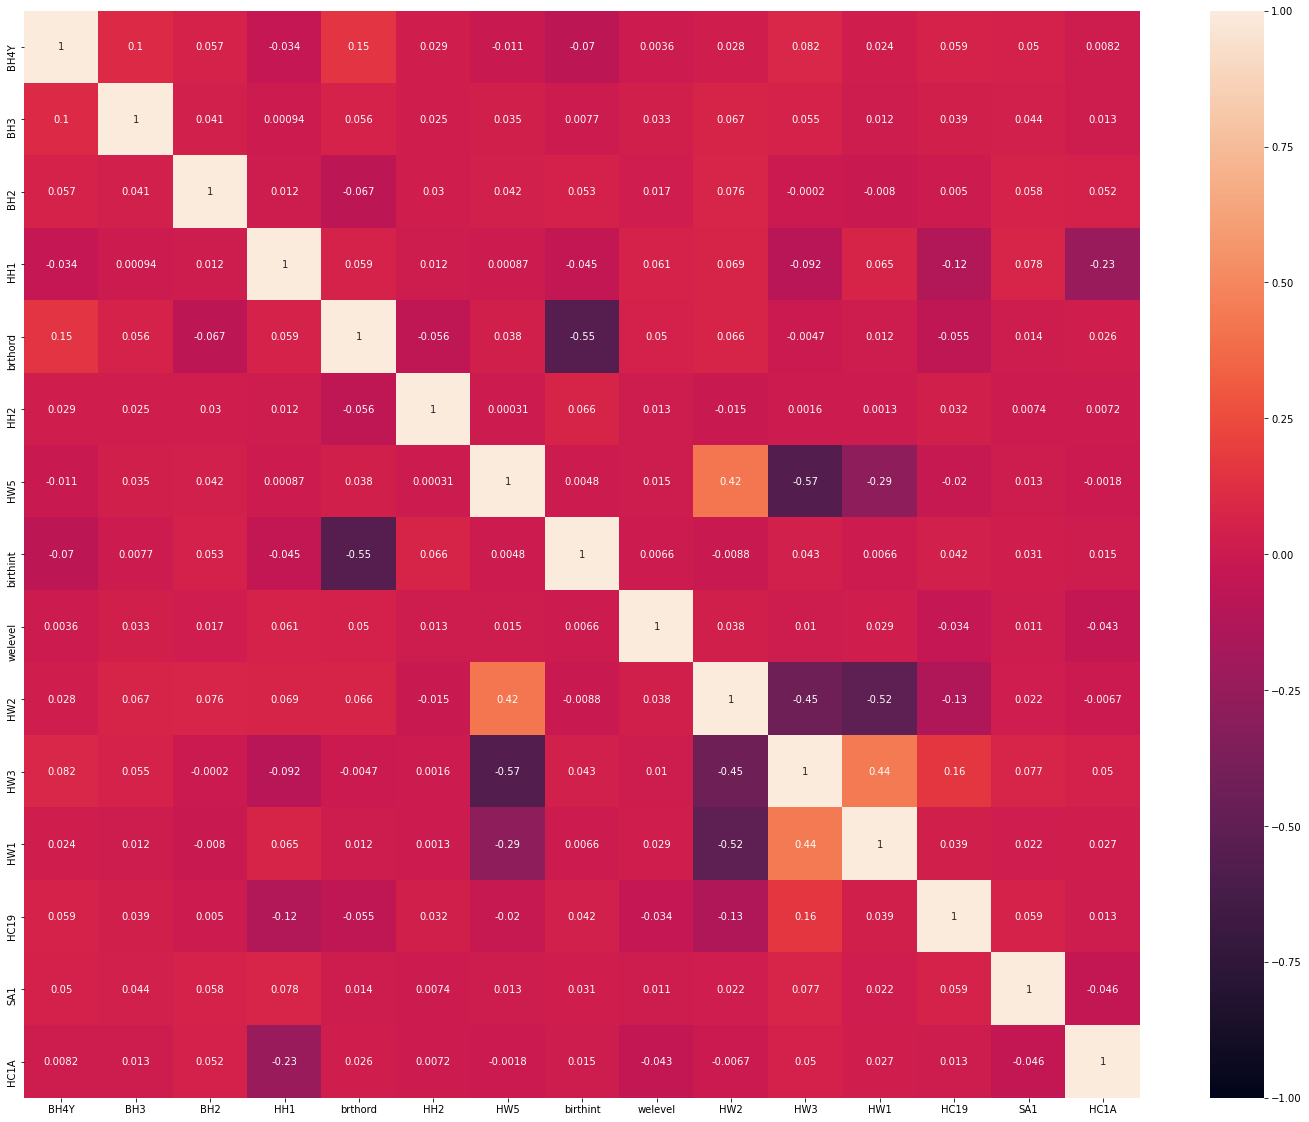

In [18]:
# X_train_rf_fs.corr()

plt.figure(figsize=(25, 20))
sns.heatmap(X_train_rf_fs.corr(), vmin=-1, vmax=1, annot=True)

## Model Implementation and comparison

### CATBoost

#### Features Selected by Chi2

In [80]:

cat_features = list(range(0, X_train_fs.shape[1]))
clf = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
    random_state = 10
)


clf.fit(X_train_fs, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test_fs, y_test), 
        verbose=False,
        plot=True
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
y_pred_catboost = clf.predict(data = X_test_fs)
acc_catboost = metrics.accuracy_score(y_test, y_pred_catboost)
f1_score_catboost = metrics.f1_score(y_test, y_pred_catboost)
recall_score_catboostt = metrics.recall_score(y_test, y_pred_catboost)
precision_score_catboostt = metrics.precision_score(y_test, y_pred_catboost)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 50, 'learning_rate': 0.3, 'loss_function': 'CrossEntropy', 'random_state': 10}


In [20]:
acc_catboost, f1_score_catboost, recall_score_catboostt, precision_score_catboostt

(0.9065194894791307,
 0.9135841836734694,
 0.9721750933152359,
 0.8616541353383459)

In [21]:
y_pred_prob = clf.predict_proba(data = X_test_fs)

In [22]:
pd.DataFrame(confusion_matrix(y_test, y_pred_catboost))

,0,1
0,2391,460
1,82,2865


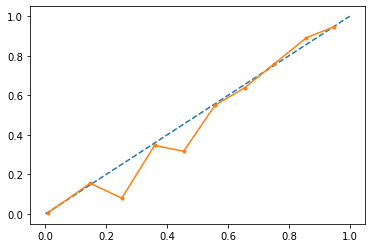

In [23]:
fop, mpv = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

#### Features Selected by Random Forest

In [24]:
cat_features = list(range(0, X_train_rf_fs.shape[1]))
clf = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
    random_state=10
)


clf.fit(X_train_rf_fs, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test_rf_fs, y_test), 
        verbose=False,
        plot=True
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())
y_pred_catboost_rf = clf.predict(data = X_test_rf_fs)
acc_catboost_rf = metrics.accuracy_score(y_test, y_pred_catboost_rf)
f1_score_catboost_rf = metrics.f1_score(y_test, y_pred_catboost_rf)
recall_score_catboost_rf = metrics.recall_score(y_test, y_pred_catboost_rf)
precision_score_catboost_rf = metrics.precision_score(y_test, y_pred_catboost_rf)

acc_catboost_rf,f1_score_catboost_rf, recall_score_catboost_rf, precision_score_catboost_rf

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 50, 'learning_rate': 0.3, 'loss_function': 'CrossEntropy', 'random_state': 10}


(0.9392894101414281,
 0.9427269768955419,
 0.9830335934848999,
 0.9055954985933105)

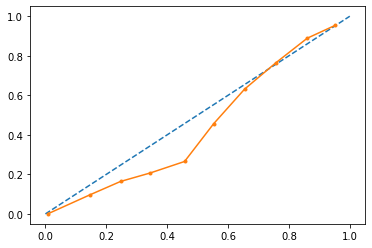

In [25]:
y_pred_prob = clf.predict_proba(data = X_test_rf_fs)
fop, mpv = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
plt.show()

### KNN

#### Features Selected by Chi2

In [26]:
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets

knn.fit(X_train_fs, y_train)
y_pred_knn_fs = knn.predict(X_test_fs)
acc_knn_fs = metrics.accuracy_score(y_test, y_pred_knn_fs)
f1_score_knn_fs = metrics.f1_score(y_test, y_pred_knn_fs)
recall_score_knn_fs = metrics.recall_score(y_test, y_pred_knn_fs)
precision_score_knn_fs = metrics.precision_score(y_test, y_pred_knn_fs)
acc_knn_fs,f1_score_knn_fs, recall_score_knn_fs, precision_score_knn_fs

(0.885995170748534, 0.8823215239451665, 0.8408551068883611, 0.9280898876404494)

In [27]:
y_pred_prob = knn.predict_proba(X_test_fs)
knn = KNeighborsClassifier(n_neighbors=3)
cal_knn = CalibratedClassifierCV(knn, cv=5)
cal_knn.fit(X_train_fs, y_train)
y_pred_cal = cal_knn.predict_proba(X_test_fs)

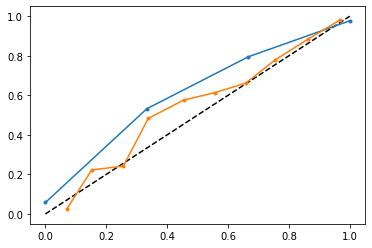

In [28]:

fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [29]:

y_pred_knn_fs_cal = cal_knn.predict(X_test_fs)
acc_knn_fs_cal = metrics.accuracy_score(y_test, y_pred_knn_fs_cal)
f1_score_knn_fs_cal = metrics.f1_score(y_test, y_pred_knn_fs_cal)
recall_score_knn_fs_cal = metrics.recall_score(y_test, y_pred_knn_fs_cal)
precision_score_knn_fs_cal = metrics.precision_score(y_test, y_pred_knn_fs_cal)
acc_knn_fs_cal,f1_score_knn_fs_cal, recall_score_knn_fs_cal, precision_score_knn_fs_cal

(0.8925491548809934,
 0.8923076923076924,
 0.8758059043094673,
 0.9094432699083862)

#### Features Selected by Random Forest

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train_rf_fs, y_train)
y_pred_knn_fs = knn.predict(X_test_rf_fs)
acc_knn_fs = metrics.accuracy_score(y_test, y_pred_knn_fs)
f1_score_knn_fs = metrics.f1_score(y_test, y_pred_knn_fs)
recall_knn_fs = metrics.recall_score(y_test, y_pred_knn_fs)
precision_score_knn_fs = metrics.precision_score(y_test, y_pred_knn_fs)
acc_knn_fs,f1_score_knn_fs, recall_score_knn_fs, precision_score_knn_fs

(0.9096240082787168,
 0.9047619047619048,
 0.8408551068883611,
 0.9741682974559687)

In [31]:
y_pred_prob = knn.predict_proba(X_test_rf_fs)
knn = KNeighborsClassifier(n_neighbors=3)
cal_knn = CalibratedClassifierCV(knn, cv=5)
cal_knn.fit(X_train_rf_fs, y_train)
y_pred_cal = cal_knn.predict_proba(X_test_rf_fs)

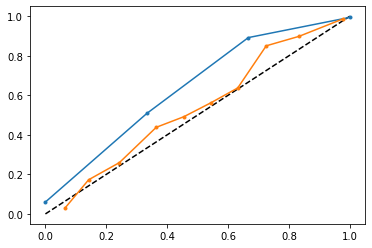

In [32]:
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [33]:
y_pred_knn_rf_fs_cal = cal_knn.predict(X_test_rf_fs)
acc_knn_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_knn_rf_fs_cal)
f1_score_knn_rf_fs_cal = metrics.f1_score(y_test, y_pred_knn_rf_fs_cal)
recall_knn_rf_fs_cal = metrics.recall_score(y_test, y_pred_knn_rf_fs_cal)
precision_score_knn_rf_fs_cal = metrics.precision_score(y_test, y_pred_knn_rf_fs_cal)
acc_knn_rf_fs_cal,f1_score_knn_rf_fs_cal, recall_knn_rf_fs_cal, precision_score_knn_rf_fs_cal

(0.9165229389444636,
 0.9152067274001402,
 0.8863250763488293,
 0.9460340456356393)

### RandomForest

#### Features Selected by Chi2

In [34]:
rf_model = RandomForestClassifier(n_estimators=1000, 
                               random_state=50)

# Fit on training data
rf_model.fit(X_train_fs, y_train)
y_pred_rf_fs = rf_model.predict(X_test_fs)
acc_rf_fs = metrics.accuracy_score(y_test, y_pred_rf_fs)
f1_score_rf_fs = metrics.f1_score(y_test, y_pred_rf_fs)
recall_score_rf_fs = metrics.recall_score(y_test, y_pred_rf_fs)
precision_score_rf_fs = metrics.precision_score(y_test, y_pred_rf_fs)
acc_rf_fs,f1_score_rf_fs, recall_score_rf_fs, precision_score_rf_fs

(0.9287685408761642, 0.930971084740097, 0.9450288428910757, 0.9173254281949934)

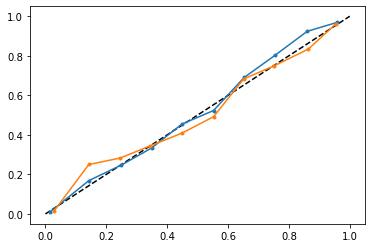

In [35]:
y_pred_prob = rf_model.predict_proba(X_test_fs) 

rf_model = RandomForestClassifier(n_estimators=1000, random_state=50)

rf_model_cal = CalibratedClassifierCV(rf_model, cv=5)
rf_model_cal.fit(X_train_fs, y_train)
y_pred_cal = rf_model_cal.predict_proba(X_test_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [36]:
y_pred_rf_fs_cal = rf_model_cal.predict(X_test_fs)
acc_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_rf_fs_cal)
f1_score_rf_fs_cal = metrics.f1_score(y_test, y_pred_rf_fs_cal)
recall_score_rf_fs_cal = metrics.recall_score(y_test, y_pred_rf_fs_cal)
precision_score_rf_fs_cal = metrics.precision_score(y_test, y_pred_rf_fs_cal)
acc_rf_fs_cal,f1_score_rf_fs_cal, recall_score_rf_fs_cal, precision_score_rf_fs_cal

(0.9301483270093136, 0.932194876946258, 0.9446895147607737, 0.9200264375413086)

#### Features Selected by RandomForest

In [37]:
rf_model = RandomForestClassifier(n_estimators=1000, 
                               random_state=50)
rf_model.fit(X_train_rf_fs, y_train)
y_pred_rf_ran_fs = rf_model.predict(X_test_rf_fs)
acc_rf_ran_fs = metrics.accuracy_score(y_test, y_pred_rf_ran_fs)
f1_score_rf_ran_fs = metrics.f1_score(y_test, y_pred_rf_ran_fs)
recall_score_rf_ran_fs = metrics.recall_score(y_test, y_pred_rf_ran_fs)
precision_score_rf_ran_fs = metrics.precision_score(y_test, y_pred_rf_ran_fs)
acc_rf_ran_fs,f1_score_rf_ran_fs, recall_score_rf_ran_fs, precision_score_rf_ran_fs

(0.9579165229389445,
 0.9595892679695264,
 0.9830335934848999,
 0.9372371400841152)

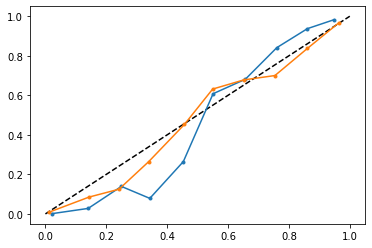

In [38]:
y_pred_prob = rf_model.predict_proba(X_test_rf_fs) 

rf_model = RandomForestClassifier(n_estimators=1000, random_state=50)

rf_model_cal = CalibratedClassifierCV(rf_model, cv=5)
rf_model_cal.fit(X_train_rf_fs, y_train)
y_pred_cal = rf_model_cal.predict_proba(X_test_rf_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [39]:
y_pred_rf_ran_fs_cal = rf_model_cal.predict(X_test_rf_fs)
acc_rf_ran_fs_cal = metrics.accuracy_score(y_test, y_pred_rf_ran_fs_cal)
f1_score_rf_ran_fs_cal = metrics.f1_score(y_test, y_pred_rf_ran_fs_cal)
recall_score_rf_ran_fs_cal = metrics.recall_score(y_test, y_pred_rf_ran_fs_cal)
precision_score_rf_ran_fs_cal = metrics.precision_score(y_test, y_pred_rf_ran_fs_cal)
acc_rf_ran_fs_cal,f1_score_rf_ran_fs_cal, recall_score_rf_ran_fs_cal, precision_score_rf_ran_fs_cal

(0.9570541566057261,
 0.9585897222684183,
 0.9779436715303699,
 0.9399869536855838)

### XGBoost

#### Features Selected by Chi2

In [40]:
xgb_model = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=100,
     max_depth=5,
     objective= 'binary:logistic',
    random_state=10
)
eval_set = [(X_train_fs, y_train),(X_test_fs, y_test)]
xgb_model.fit(X_train_fs, y_train,early_stopping_rounds=10, eval_metric=["error", 'logloss'], eval_set=eval_set, verbose=False)

y_pred_xgb_fs = xgb_model.predict(X_test_fs)

acc_xgb_fs = metrics.accuracy_score(y_test, y_pred_xgb_fs)

f1_score_xgb_fs = metrics.f1_score(y_test, y_pred_xgb_fs)

recall_score_xgb_fs = metrics.recall_score(y_test, y_pred_xgb_fs)

precision_score_xgb_fs = metrics.precision_score(y_test, y_pred_xgb_fs)

acc_xgb_fs,f1_score_xgb_fs, recall_score_xgb_fs, precision_score_xgb_fs

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9166954122111073,
 0.9221846302561625,
 0.9711571089243298,
 0.8779141104294479)

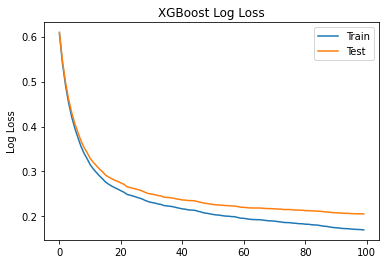

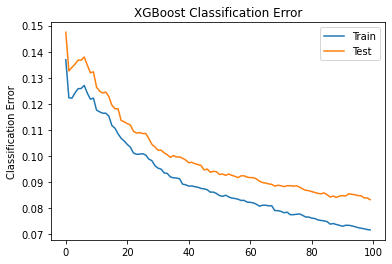

In [41]:
results_ch2 = xgb_model.evals_result()
epochs = len(results_ch2['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results_ch2['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results_ch2['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results_ch2['validation_0']['error'], label='Train')
ax.plot(x_axis, results_ch2['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


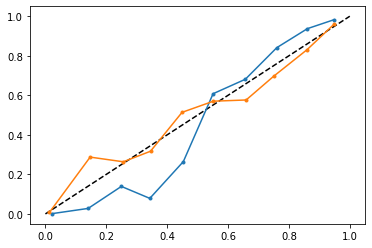

In [42]:
xgb_model = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=100,
     max_depth=5,
     objective= 'binary:logistic',
    random_state=10
)

xg_boost_cal = CalibratedClassifierCV(xgb_model, cv=5)
xg_boost_cal.fit(X_train_fs, y_train)
y_pred_cal = xg_boost_cal.predict_proba(X_test_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [43]:
y_pred_xg_fs_cal = xg_boost_cal.predict(X_test_fs)
acc_xg_fs_cal = metrics.accuracy_score(y_test, y_pred_xg_fs_cal)
f1_score_xg_fs_cal = metrics.f1_score(y_test, y_pred_xg_fs_cal)
recall_score_xg_fs_cal = metrics.recall_score(y_test, y_pred_xg_fs_cal)
precision_score_xg_fs_cal = metrics.precision_score(y_test, y_pred_xg_fs_cal)
acc_xg_fs_cal,f1_score_xg_fs_cal, recall_score_xg_fs_cal, precision_score_xg_fs_cal

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.917902725077613, 0.9221204188481676, 0.9562266711910418, 0.8903633491311217)

#### Features Selected by RandomForest

In [44]:
xgb_model = xgb.XGBClassifier(
 learning_rate =0.15,
 n_estimators=100,
 max_depth=5,
 objective= 'binary:logistic',
 seed=27,
 random_state=10
)
eval_set = [(X_train_rf_fs, y_train),(X_test_rf_fs, y_test)]

xgb_model.fit(X_train_rf_fs, y_train, early_stopping_rounds=10, eval_metric=["error", 'logloss'], eval_set=eval_set, verbose=False)

y_pred_xgb_rf_fs = xgb_model.predict(X_test_rf_fs)

acc_xgb_rf_fs = metrics.accuracy_score(y_test, y_pred_xgb_rf_fs)

f1_score_xgb_rf_fs = metrics.f1_score(y_test, y_pred_xgb_rf_fs)

recall_score_xgb_rf_fs = metrics.recall_score(y_test, y_pred_xgb_rf_fs)

precision_score_xgb_rf_fs = metrics.precision_score(y_test, y_pred_xgb_rf_fs)

acc_xgb_rf_fs,f1_score_xgb_rf_fs, recall_score_xgb_rf_fs, precision_score_xgb_rf_fs

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9467057606071059,
 0.9494354442808051,
 0.9843909060061079,
 0.9168773704171934)

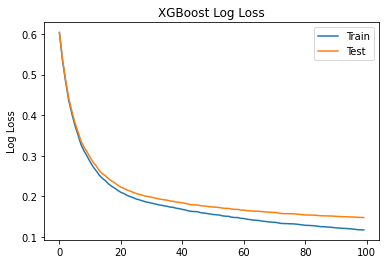

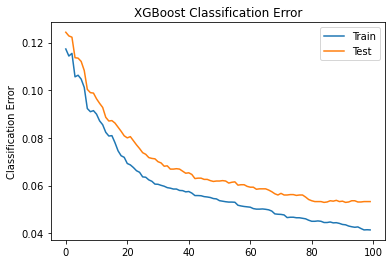

In [45]:
# xgb_model.evals_result()
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[17:59:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


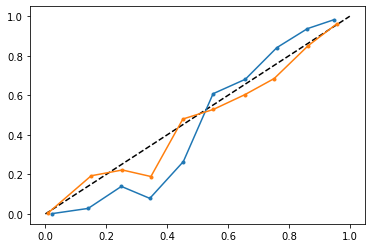

In [46]:
xgb_model = xgb.XGBClassifier(
     learning_rate =0.15,
     n_estimators=100,
     max_depth=5,
     objective= 'binary:logistic',
    random_state=10
)

xg_boost_cal = CalibratedClassifierCV(xgb_model, cv=5)
xg_boost_cal.fit(X_train_rf_fs, y_train)
y_pred_cal = xg_boost_cal.predict_proba(X_test_rf_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [47]:
y_pred_xg_rf_fs_cal = xg_boost_cal.predict(X_test_rf_fs)
acc_xg_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_xg_rf_fs_cal)
f1_score_xg_rf_fs_cal = metrics.f1_score(y_test, y_pred_xg_rf_fs_cal)
recall_score_xg_rf_fs_cal = metrics.recall_score(y_test, y_pred_xg_rf_fs_cal)
precision_score_xg_rf_fs_cal = metrics.precision_score(y_test, y_pred_xg_rf_fs_cal)
acc_xg_rf_fs_cal,f1_score_xg_rf_fs_cal, recall_score_xg_rf_fs_cal, precision_score_xg_rf_fs_cal

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


(0.9506726457399103,
 0.9527272727272728,
 0.9779436715303699,
 0.9287786013535289)

### Logistic Regression

#### Features Selected by Chi2

In [48]:
log = LogisticRegression(random_state=10)
log.fit(X_train_fs, y_train)
y_pred_log_fs = log.predict(X_test_fs)
acc_log_fs = metrics.accuracy_score(y_test, y_pred_log_fs)
f1_score_log_fs = metrics.f1_score(y_test, y_pred_log_fs)
recall_score_log_fs = metrics.recall_score(y_test, y_pred_log_fs)
precision_score_log_fs = metrics.precision_score(y_test, y_pred_log_fs)
acc_log_fs,f1_score_log_fs, recall_score_log_fs, precision_score_log_fs

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.835288030355295, 0.8417039615448366, 0.8615541228367831, 0.8227478937135451)

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

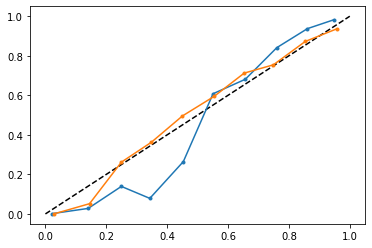

In [49]:
log = LogisticRegression(random_state=10)
log_cal = CalibratedClassifierCV(log, cv=4)
log_cal.fit(X_train_fs, y_train)
y_pred_cal = log_cal.predict_proba(X_test_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [50]:
y_pred_log_fs_cal = log_cal.predict(X_test_fs)
acc_log_fs_cal = metrics.accuracy_score(y_test, y_pred_log_fs_cal)
f1_score_log_fs_cal = metrics.f1_score(y_test, y_pred_log_fs_cal)
recall_score_log_fs_cal = metrics.recall_score(y_test, y_pred_log_fs_cal)
precision_score_log_fs_cal = metrics.precision_score(y_test, y_pred_log_fs_cal)
acc_log_fs_cal,f1_score_log_fs_cal, recall_score_log_fs_cal, precision_score_log_fs_cal

(0.8333908244222146,
 0.8412750575090371,
 0.8686800135731252,
 0.8155463523415101)

#### Features Selected by RandomForest

In [51]:
log = LogisticRegression(random_state=10)
log.fit(X_train_rf_fs, y_train)
y_pred_log_rf_fs = log.predict(X_test_rf_fs)
acc_log_rf_fs = metrics.accuracy_score(y_test, y_pred_log_rf_fs)
f1_score_log_rf_fs = metrics.f1_score(y_test, y_pred_log_rf_fs)
recall_score_log_rf_fs = metrics.recall_score(y_test, y_pred_log_rf_fs)
precision_score_log_rf_fs = metrics.precision_score(y_test, y_pred_log_rf_fs)
acc_log_rf_fs,f1_score_log_rf_fs, recall_score_log_rf_fs, precision_score_log_rf_fs

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.7233528803035529,
 0.7406209573091851,
 0.7770614183915847,
 0.7074451652764906)

C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

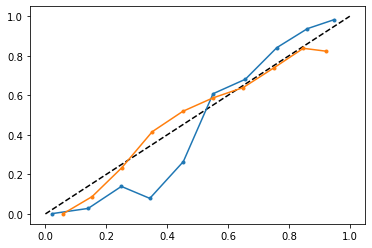

In [52]:
log = LogisticRegression(random_state=10)
log_cal = CalibratedClassifierCV(log, cv=4)
log_cal.fit(X_train_rf_fs, y_train)
y_pred_cal = log_cal.predict_proba(X_test_rf_fs)
fop_uncalibrated, mpv_uncalibrated = calibration_curve(y_test, y_pred_prob[:,1], n_bins=10, normalize=True)
fop_calibrated, mpv_calibrated = calibration_curve(y_test, y_pred_cal[:,1], n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliabilities
plt.plot(mpv_uncalibrated, fop_uncalibrated, marker='.')
plt.plot(mpv_calibrated, fop_calibrated, marker='.')

In [53]:
y_pred_log_rf_fs_cal = log_cal.predict(X_test_rf_fs)
acc_log_rf_fs_cal = metrics.accuracy_score(y_test, y_pred_log_rf_fs_cal)
f1_score_log_rf_fs_cal = metrics.f1_score(y_test, y_pred_log_rf_fs_cal)
recall_score_log_rf_fs_cal = metrics.recall_score(y_test, y_pred_log_rf_fs_cal)
precision_score_log_rf_fs_cal = metrics.precision_score(y_test, y_pred_log_rf_fs_cal)
acc_log_rf_fs_cal,f1_score_log_rf_fs_cal, recall_score_log_rf_fs_cal, precision_score_log_rf_fs_cal

(0.7033459813728872,
 0.7082767978290366,
 0.7085171360705802,
 0.7080366225839267)

### Result Comparison

#### Comparison Table

In [54]:

results_dict = {'Model':['CatBoost', 'KNN', 'RandomForest', 'XGBoost', 'LogisticRegression']*2,
                'Feature Selection':['Chi2', 'RandomForest']*5,
                'Accuracy':[acc_catboost
            ,acc_catboost_rf
            ,acc_knn_fs_cal
            ,acc_knn_rf_fs_cal
            ,acc_rf_fs_cal
            ,acc_rf_ran_fs
            ,acc_xg_fs_cal
            ,acc_xg_rf_fs_cal
            ,acc_log_fs_cal
            ,acc_log_rf_fs_cal],
            'F1 Score':[f1_score_catboost
            ,f1_score_catboost_rf
            ,f1_score_knn_fs_cal
            ,f1_score_knn_rf_fs_cal
            ,f1_score_rf_fs_cal
            ,f1_score_rf_ran_fs
            ,f1_score_xg_fs_cal
            ,f1_score_xg_rf_fs_cal
            ,f1_score_log_fs_cal
            ,f1_score_log_rf_fs_cal],
            'Precision':[precision_score_catboostt
            ,precision_score_catboost_rf
            ,precision_score_knn_fs_cal
            ,precision_score_knn_rf_fs_cal
            ,precision_score_rf_fs_cal
            ,precision_score_rf_ran_fs
            ,precision_score_xg_fs_cal
            ,precision_score_xgb_rf_fs
            ,precision_score_log_fs_cal
            ,precision_score_log_rf_fs_cal],
            'Recall':[recall_score_catboostt
            ,recall_score_catboost_rf
            ,recall_score_knn_fs_cal
            ,recall_knn_rf_fs_cal
            ,recall_score_rf_fs_cal
            ,recall_score_rf_ran_fs
            ,recall_score_xg_fs_cal
            ,recall_score_xg_rf_fs_cal
            ,recall_score_log_fs_cal
            ,recall_score_log_rf_fs_cal]
         }



In [55]:
results = pd.DataFrame(results_dict)

In [81]:
results.sort_values(by=['F1 Score'], ascending=False, inplace=True)

In [57]:
results.set_index(['Model','Feature Selection'], inplace=True)

In [82]:
results

,,Accuracy,F1 Score,Precision,Recall
Model,Feature Selection,,,,
CatBoost,RandomForest,0.957917,0.959589,0.937237,0.983034
RandomForest,RandomForest,0.950673,0.952727,0.916877,0.977944
KNN,RandomForest,0.939289,0.942727,0.905595,0.983034
LogisticRegression,Chi2,0.930148,0.932195,0.920026,0.944690
KNN,Chi2,0.917903,0.922120,0.890363,0.956227
XGBoost,RandomForest,0.916523,0.915207,0.946034,0.886325
CatBoost,Chi2,0.906519,0.913584,0.861654,0.972175
RandomForest,Chi2,0.892549,0.892308,0.909443,0.875806
XGBoost,Chi2,0.833391,0.841275,0.815546,0.868680


#### ROC Curves

0:	learn: 0.5248825	total: 18.5ms	remaining: 908ms
1:	learn: 0.4335592	total: 21.4ms	remaining: 513ms
2:	learn: 0.3756510	total: 23.9ms	remaining: 375ms
3:	learn: 0.3347213	total: 26.8ms	remaining: 308ms
4:	learn: 0.3020711	total: 29.7ms	remaining: 268ms
5:	learn: 0.2821056	total: 32.6ms	remaining: 239ms
6:	learn: 0.2617812	total: 35.4ms	remaining: 218ms
7:	learn: 0.2453212	total: 38.3ms	remaining: 201ms
8:	learn: 0.2374197	total: 41ms	remaining: 187ms
9:	learn: 0.2281541	total: 43.7ms	remaining: 175ms
10:	learn: 0.2215533	total: 46.4ms	remaining: 164ms
11:	learn: 0.2168334	total: 48.8ms	remaining: 155ms
12:	learn: 0.2123707	total: 51.2ms	remaining: 146ms
13:	learn: 0.2083683	total: 53.7ms	remaining: 138ms
14:	learn: 0.2046141	total: 56.1ms	remaining: 131ms
15:	learn: 0.2015673	total: 58.5ms	remaining: 124ms
16:	learn: 0.1993986	total: 61.2ms	remaining: 119ms
17:	learn: 0.1958138	total: 63.9ms	remaining: 114ms
18:	learn: 0.1926530	total: 66.4ms	remaining: 108ms
19:	learn: 0.1902192	tot

C:\Users\cheta\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cheta\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\cheta\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


No Skill: ROC AUC=0.500
CatBoost: ROC AUC=0.977
Random Forest: ROC AUC=0.986
XGBoost: ROC AUC=0.982
KNN: ROC AUC=0.968
Logistic Regression: ROC AUC=0.801


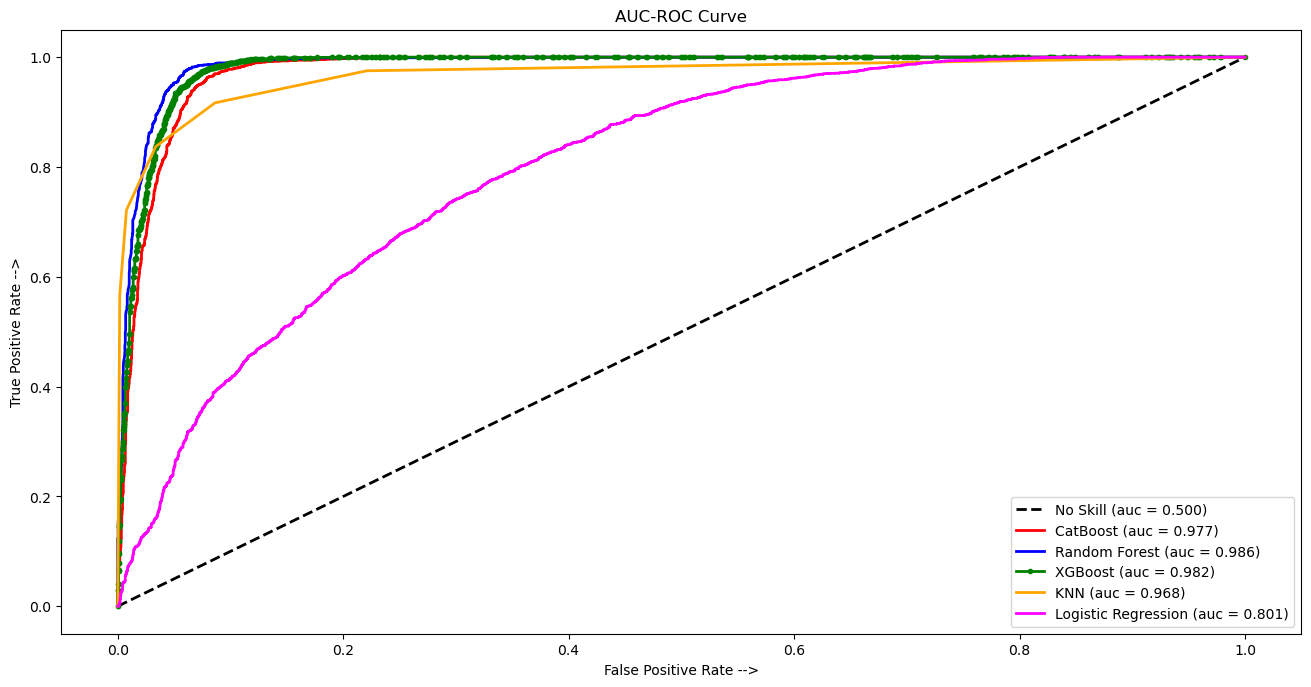

In [60]:
ns_probs = [0 for _ in range(len(y_test))]


# fit a model
SEED=1
cat_clf = CatBoostClassifier(
    iterations=50, 
    learning_rate=0.3, 
    loss_function='CrossEntropy',
    random_state=SEED
)
rf_clf = RandomForestClassifier(n_estimators=1000, 
                               random_state=SEED)
xgb_clf = xgb.XGBClassifier(
         learning_rate =0.15,
         n_estimators=100,
         max_depth=5,
         objective= 'binary:logistic',
         random_state=SEED)
knn_clf = KNeighborsClassifier()
log_clf = LogisticRegression(random_state=SEED)

# trains the classifiers
cat_clf.fit(X_train_rf_fs, y_train)
rf_clf.fit(X_train_rf_fs, y_train)
xgb_clf.fit(X_train_rf_fs, y_train)
knn_clf.fit(X_train_rf_fs, y_train)
log_clf.fit(X_train_rf_fs, y_train)


# predict probabilities
cat_probs = cat_clf.predict_proba(X_test_rf_fs)
rf_probs = rf_clf.predict_proba(X_test_rf_fs)
xgb_probs = xgb_clf.predict_proba(X_test_rf_fs)
knn_probs = knn_clf.predict_proba(X_test_rf_fs)
log_probs = log_clf.predict_proba(X_test_rf_fs)

# keep probabilities for the positive outcome only
cat_probs = cat_probs[:, 1]
rf_probs = rf_probs[:, 1]
xgb_probs = xgb_probs[:, 1]
knn_probs = knn_probs[:, 1]
log_probs = log_probs[:, 1]

# calculate scores

ns_auc = roc_auc_score(y_test, ns_probs)
cat_auc = roc_auc_score(y_test, cat_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
knn_auc = roc_auc_score(y_test, knn_probs)
log_auc = roc_auc_score(y_test, log_probs)


# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('CatBoost: ROC AUC=%.3f' % (cat_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))
print('XGBoost: ROC AUC=%.3f' % (xgb_auc))
print('KNN: ROC AUC=%.3f' % (knn_auc))
print('Logistic Regression: ROC AUC=%.3f' % (log_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
cat_fpr, cat_tpr, _ = roc_curve(y_test, cat_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)



# plot the roc curve for the model
plt.figure(figsize=(16,8), dpi=100)

plt.plot(ns_fpr, ns_tpr, linestyle='dashed', linewidth=2, color= 'black', label='No Skill (auc = %0.3f)' % ns_auc)
plt.plot(cat_fpr, cat_tpr, linestyle='-', linewidth=2, color= 'red', label='CatBoost (auc = %0.3f)' % cat_auc)
plt.plot(rf_fpr, rf_tpr, linestyle='-', linewidth=2, color= 'blue', label='Random Forest (auc = %0.3f)' % rf_auc)
plt.plot(xgb_fpr, xgb_tpr, marker='.', linewidth=2, color= 'green', label='XGBoost (auc = %0.3f)' % xgb_auc)
plt.plot(knn_fpr, knn_tpr, linestyle='-', linewidth=2, color= 'orange', label='KNN (auc = %0.3f)' % knn_auc)
plt.plot(log_fpr, log_tpr, linestyle='-', linewidth=2, color= 'magenta', label='Logistic Regression (auc = %0.3f)' % log_auc)


# axis labels
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title("AUC-ROC Curve")
plt.legend()

plt.show()

#### Calibration Curves

In [63]:
import scikitplot as skplt

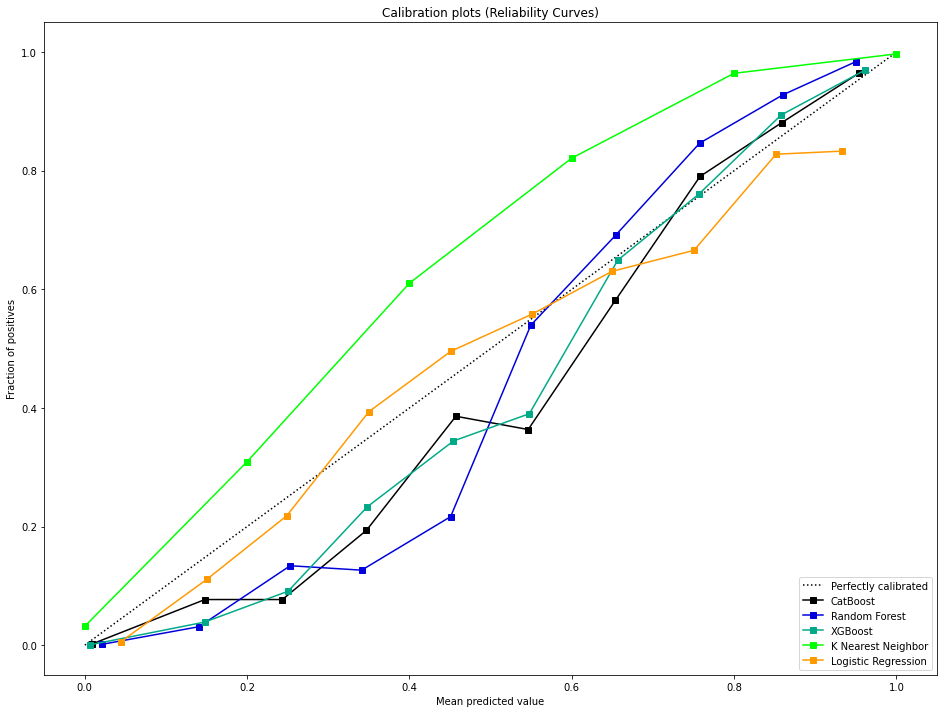

In [64]:
probas_list = [cat_probs, rf_probs, xgb_probs, knn_probs, log_probs]

clf_names = ['CatBoost', 'Random Forest', 'XGBoost', 'K Nearest Neighbor', 'Logistic Regression']

skplt.metrics.plot_calibration_curve(y_test, probas_list, clf_names, figsize=(16,12))
plt.show()